# Tutorial 2
We show how to train DeepScalper on FX trading.

## Step 1: Import Packages
Modify the system path and load the corresponding packages and functions 

In [1]:
import os
import sys

import warnings
warnings.filterwarnings("ignore")

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)

import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from trademaster.utils import plotfrom trademaster.utils import set_seedset_seed(2023)

2023-03-02 14:37:51,629	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8266
2023-03-02 14:37:53,616	INFO worker.py:973 -- Calling ray.init() again after it has already been called.


## Step 2: Load Configs
Load default config from the file `configs/algorithmic_trading/algorithmic_trading_FX_deepscalper_deepscalper_adam_mse.py`

In [2]:

parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "configs", "algorithmic_trading", "algorithmic_trading_FX_deepscalper_deepscalper_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")
args, _= parser.parse_known_args()

cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

In [3]:
cfg

Config (path: /data/sunshuo/qml/TradeMaster/configs/algorithmic_trading/algorithmic_trading_FX_deepscalper_deepscalper_adam_mse.py): {'data': {'type': 'AlgorithmicTradingDataset', 'data_path': 'data/algorithmic_trading/FX', 'train_path': 'data/algorithmic_trading/FX/train.csv', 'valid_path': 'data/algorithmic_trading/FX/valid.csv', 'test_path': 'data/algorithmic_trading/FX/test.csv', 'test_dynamic_path': 'data/algorithmic_trading/FX/test_labeled_3_24_-0.05_0.05.csv', 'tech_indicator_list': ['high', 'low', 'open', 'close', 'adjcp', 'zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'backward_num_day': 5, 'forward_num_day': 5, 'test_dynamic': '-1'}, 'environment': {'type': 'AlgorithmicTradingEnvironment'}, 'agent': {'type': 'AlgorithmicTradingDQN', 'max_step': 12345, 'reward_scale': 1, 'repeat_times': 1, 'gamma': 0.9, 'batch_size': 64, 'clip_grad_norm': 3.0, 'soft_update_tau': 0, 'state_value_tau': 0.005}, 'trainer': {'type': 'AlgorithmicT

## Step 3: Build Dataset

In [4]:
dataset = build_dataset(cfg)

## Step 4: Build Reinforcement Learning Environments
Build environments based on cfg and predefined dataset

In [5]:
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))

In [6]:
train_environment.df.head()

,date,close,tic,open,high,low,adjcp,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
0,2000-01-04,0.120774,YUAN,0.120774,0.120774,0.120774,0.120774,0.0,0.0,0.0,0.0,-0.000012,-0.004914,-0.005947,-0.005263,-0.003942,-0.004124,-0.003351
1,2000-01-05,0.120776,YUAN,0.120776,0.120776,0.120776,0.120776,0.0,0.0,0.0,0.0,0.000012,-0.004914,-0.005947,-0.005263,-0.003942,-0.004124,-0.003351
2,2000-01-06,0.120777,YUAN,0.120777,0.120777,0.120777,0.120777,0.0,0.0,0.0,0.0,0.000012,-0.004914,-0.005947,-0.005263,-0.003942,-0.004124,-0.003351
3,2000-01-07,0.120782,YUAN,0.120782,0.120782,0.120782,0.120782,0.0,0.0,0.0,0.0,0.000036,-0.000039,-0.005947,-0.005263,-0.003942,-0.004124,-0.003351
4,2000-01-10,0.120782,YUAN,0.120782,0.120782,0.120782,0.120782,0.0,0.0,0.0,0.0,0.000000,-0.000029,-0.005947,-0.005263,-0.003942,-0.004124,-0.003351


## Step 5: Build Net 
Update information about the state and action dimension. Create networks and optimizer for DeepScalper


In [7]:
action_dim = train_environment.action_dim
state_dim = train_environment.state_dim

cfg.act.update(dict(action_dim=action_dim, state_dim=state_dim))
act = build_net(cfg.act)
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
if cfg.cri:
    cfg.cri.update(dict(action_dim=action_dim, state_dim=state_dim))
    cri = build_net(cfg.cri)
    cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))
else:
    cri = None
    cri_optimizer = None

## Step 6: Build Loss

In [8]:
criterion = build_loss(cfg)

## Step 7: Build Transition

In [9]:
transition = build_transition(cfg)


## Step 8: Build Agent

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = build_agent(cfg, default_args=dict(action_dim = action_dim,state_dim = state_dim,act = act,cri = cri,act_optimizer = act_optimizer,cri_optimizer = cri_optimizer, criterion = criterion,transition = transition,device=device))

## Step 9: Build Trainer
Build trainer from config and create work directionary to save the result, model and config

In [11]:
trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))

| Arguments Keep work_dir: /data/sunshuo/qml/TradeMaster/work_dir/algorithmic_trading_FX_deepscalper_deepscalper_adam_mse


## Step 10: Train the RL Agent
Train the trainer based on the config and save results in workdir

In [12]:
trainer.train_and_valid()

Train Episode: [1/20]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  -0.096750%  | -124.108494 | 0.000196%  |  0.137177%   |
+--------------+-------------+------------+--------------+
Valid Episode: [1/20]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  0.000905%   |   7.226111  | 0.000090%  |  0.001914%   |
+--------------+-------------+------------+--------------+
Train Episode: [2/20]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  0.017753%   |  49.035435  | 0.000091%  |  0.006434%   |
+--------------+-------------+------------+--------------+
Valid Episode: [2/20]
+--------------+-----------

## Step 11: RL Agent Testing

In [13]:
trainer.test();

Resume checkpoint /data/sunshuo/qml/TradeMaster/work_dir/algorithmic_trading_FX_deepscalper_deepscalper_adam_mse/checkpoints/best.pth
Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  -0.142947%  | -979.346013 | 0.000104%  |  0.142947%   |
+--------------+-------------+------------+--------------+


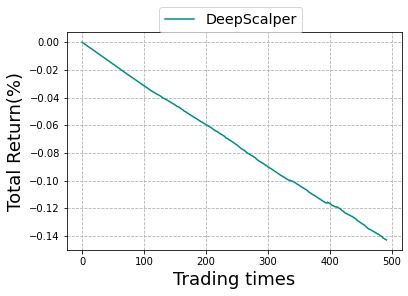

In [14]:
plot(trainer.test_environment.save_asset_memory(),alg="DeepScalper")